In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, zscore, probplot

df = pd.read_csv('Superstore.csv', encoding='latin1')

df.columns = df.columns.str.replace(' ', '_').str.replace('-', '_')

df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%m/%d/%Y')
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'], format='%m/%d/%Y')

categorical_cols = ['Ship_Mode', 'Segment', 'Region', 'Category', 'Sub_Category']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')
        
print(f"Total Rows: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")

print("\n--- Missing Value Check ---")
print(df.isnull().sum().to_markdown(numalign='left', stralign='left'))

print("\n--- Descriptive Statistics (Numerical) ---")
print(df[['Sales', 'Quantity', 'Discount', 'Profit']].describe().T.to_markdown(numalign='left', stralign='left'))

Total Rows: 9994
Total Columns: 21

--- Missing Value Check ---
|               | 0   |
|:--------------|:----|
| Row_ID        | 0   |
| Order_ID      | 0   |
| Order_Date    | 0   |
| Ship_Date     | 0   |
| Ship_Mode     | 0   |
| Customer_ID   | 0   |
| Customer_Name | 0   |
| Segment       | 0   |
| Country       | 0   |
| City          | 0   |
| State         | 0   |
| Postal_Code   | 0   |
| Region        | 0   |
| Product_ID    | 0   |
| Category      | 0   |
| Sub_Category  | 0   |
| Product_Name  | 0   |
| Sales         | 0   |
| Quantity      | 0   |
| Discount      | 0   |
| Profit        | 0   |

--- Descriptive Statistics (Numerical) ---
|          | count   | mean     | std      | min      | 25%     | 50%    | 75%    | max     |
|:---------|:--------|:---------|:---------|:---------|:--------|:-------|:-------|:--------|
| Sales    | 9994    | 229.858  | 623.245  | 0.444    | 17.28   | 54.49  | 209.94 | 22638.5 |
| Quantity | 9994    | 3.78957  | 2.22511  | 1        | 2 

In [3]:
print("Quantification of Missing Data:")
print(df.isnull().sum().loc[lambda x: x > 0]) 

if df.isnull().sum().sum() == 0:
    print("\nConclusion: The dataset has NO missing values. No imputation or removal is required.")
    print("Messiness Mechanism: Not Applicable (Data is Completely Recorded).")
    
missing_summary = pd.DataFrame({
    'Variable': df.columns,
    'Missing Count': df.isnull().sum(),
    'Handling Strategy': ['No Action Required'] * len(df.columns),
    'Impact': ['No influence on later analysis'] * len(df.columns)
})
print("\n--- Missing Data Strategy Summary ---")
print(missing_summary[missing_summary['Missing Count'] > 0].to_markdown(index=False)) 

Quantification of Missing Data:
Series([], dtype: int64)

Conclusion: The dataset has NO missing values. No imputation or removal is required.
Messiness Mechanism: Not Applicable (Data is Completely Recorded).

--- Missing Data Strategy Summary ---
| Variable   | Missing Count   | Handling Strategy   | Impact   |
|------------|-----------------|---------------------|----------|


In [4]:
numerical_cols = ['Sales', 'Profit', 'Quantity', 'Discount']

def calculate_advanced_stats(data, cols):
    stats = data[cols].agg([
        'mean', 'median', lambda x: x.mode()[0], 'std', 'var', 'min', 'max'
    ]).T
    stats.columns = ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Variance', 'Min', 'Max']
    stats['IQR'] = data[cols].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))
    stats['Skewness'] = data[cols].apply(lambda x: skew(x, bias=False))
    stats['Kurtosis'] = data[cols].apply(lambda x: kurtosis(x, bias=False))
    return stats[['Mean', 'Median', 'Mode', 'Standard Deviation', 'IQR', 'Skewness', 'Kurtosis']]

advanced_stats = calculate_advanced_stats(df, numerical_cols)
print("--- Advanced Summary Statistics ---")
print(advanced_stats.to_markdown(numalign='left', stralign='left'))

--- Advanced Summary Statistics ---
|          | Mean     | Median   | Mode   | Standard Deviation   | IQR     | Skewness   | Kurtosis   |
|:---------|:---------|:---------|:-------|:---------------------|:--------|:-----------|:-----------|
| Sales    | 229.858  | 54.49    | 12.96  | 623.245              | 192.66  | 12.9728    | 305.312    |
| Profit   | 28.6569  | 8.6665   | 0      | 234.26               | 27.6352 | 7.56143    | 397.189    |
| Quantity | 3.78957  | 3        | 3      | 2.22511              | 3       | 1.27854    | 1.99189    |
| Discount | 0.156203 | 0.2      | 0      | 0.206452             | 0.2     | 1.68429    | 2.40955    |


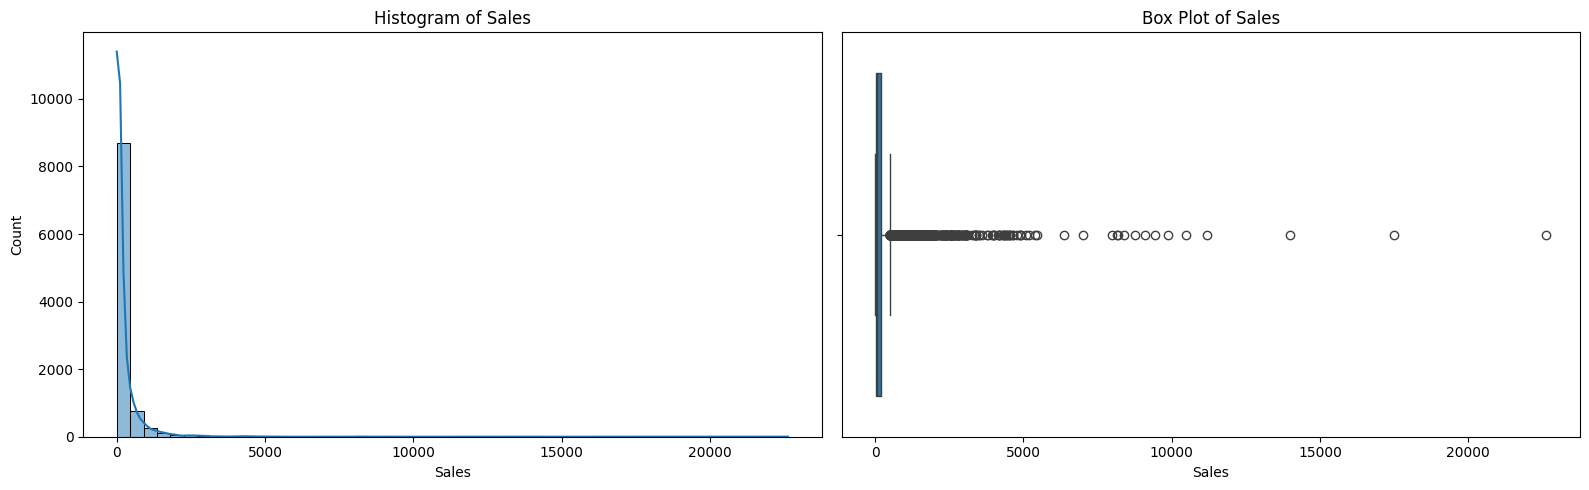

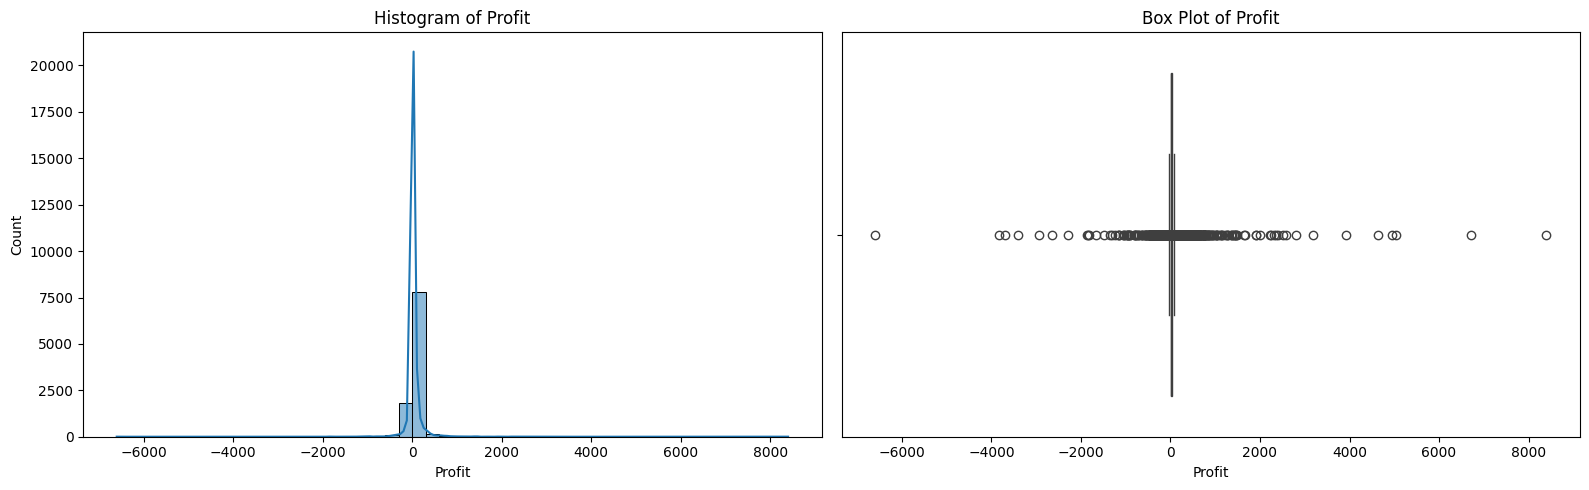

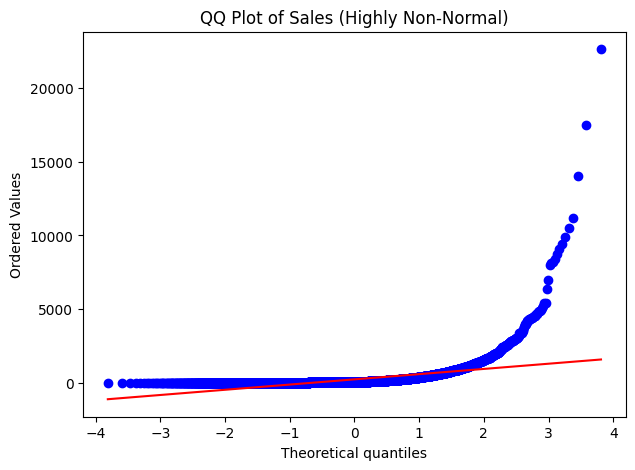

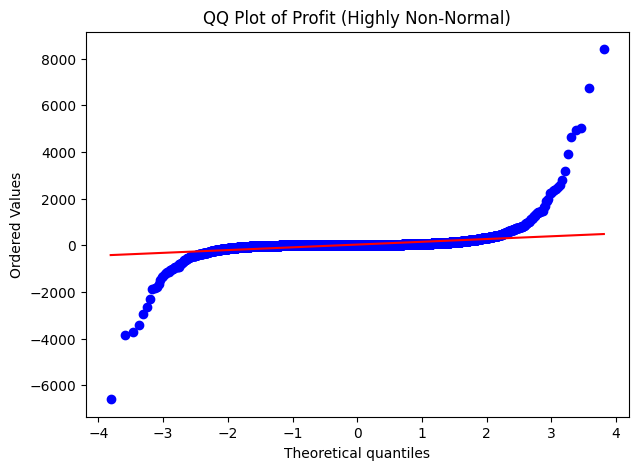

In [5]:
focus_cols = ['Sales', 'Profit']

for col in focus_cols:
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Histogram of {col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.tight_layout()
    plt.show()

for col in focus_cols:
    plt.figure(figsize=(7, 5))
    probplot(df[col], dist="norm", plot=plt)
    plt.title(f'QQ Plot of {col} (Highly Non-Normal)')
    plt.show()

In [37]:
# CODE: Outlier Detection using IQR Method
print("\n--- Outlier Detection (IQR Method) ---")
outlier_summary = {}
for col in focus_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    outlier_summary[col] = outlier_count
    print(f"{col}: {outlier_count} outliers (Below {lower_bound:.2f} or Above {upper_bound:.2f})")


--- Outlier Detection (IQR Method) ---
Sales: 1167 outliers (Below -271.71 or Above 498.93)
Profit: 1881 outliers (Below -39.72 or Above 70.82)


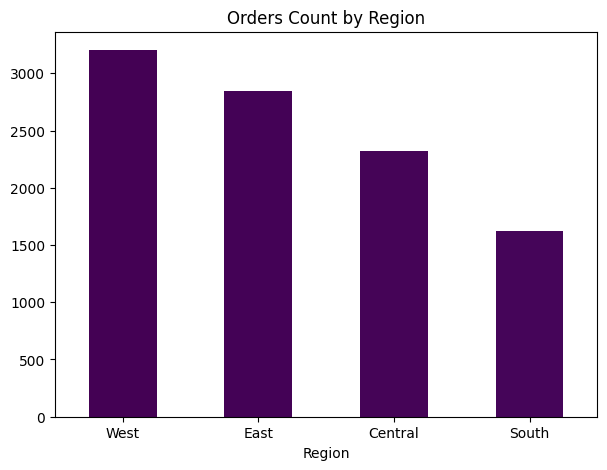

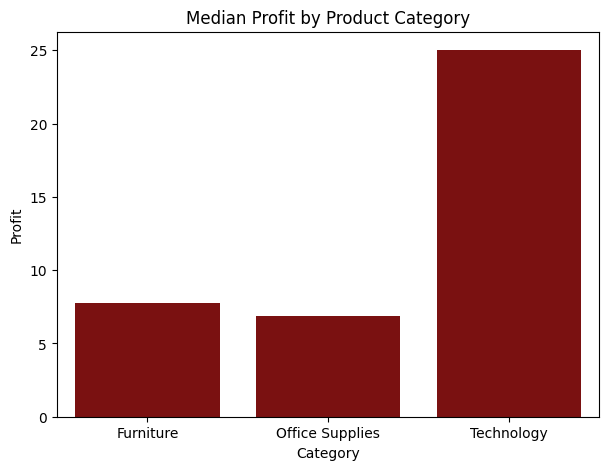

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(7, 5))
df['Region'].value_counts().plot(kind='bar', color=sns.color_palette("viridis", as_cmap=True).colors)
plt.title('Orders Count by Region')
plt.xticks(rotation=0)
plt.show()

category_profit = df.groupby('Category', observed=True)['Profit'].median().sort_values(ascending=False).reset_index()

plt.figure(figsize=(7, 5))

sns.barplot(x='Category', y='Profit', data=category_profit, color='darkred') 

plt.title('Median Profit by Product Category')

print("\n")
plt.show()

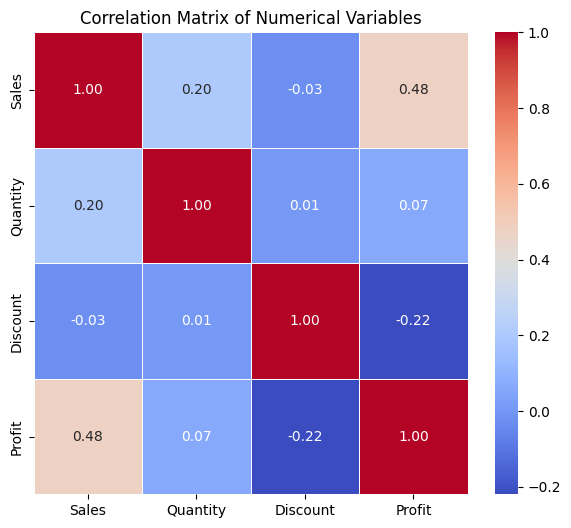

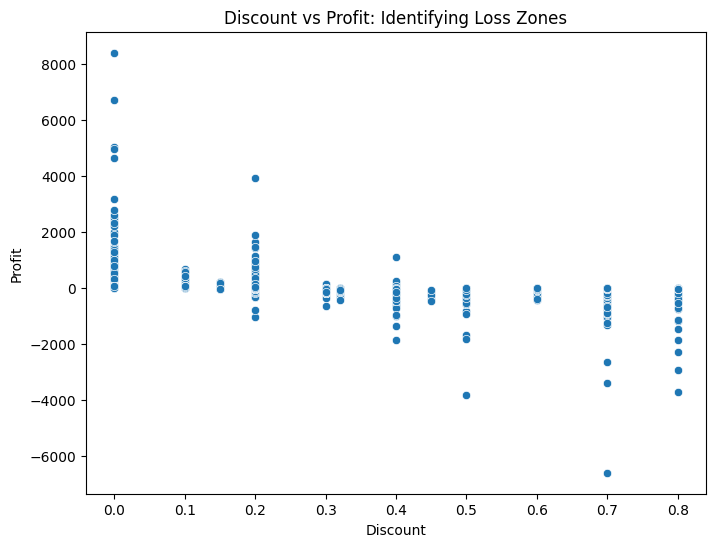

In [7]:
correlation_matrix = df[['Sales', 'Quantity', 'Discount', 'Profit']].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Discount', y='Profit', data=df)
plt.title('Discount vs Profit: Identifying Loss Zones')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.show()

## Step 6: Handling Outliers

# 1. Identifying Outliers (Using IQR Method as justified in Step 4)
print("Outlier Detection Method: IQR Method (Most appropriate for highly skewed Sales/Profit data).")

# 2. Deciding How to Handle Outliers
print("\nDecision: **Keep the Outliers** for EDA.")

# Justification
print("Justification:")
print("* Outliers in Sales/Profit represent **valid, extreme business events** (large deals, high losses).")
print("* Removing them would cause loss of critical information, especially regarding the profitability problem (losses).")
print("* We will use **median-based statistics** for analysis as they are robust to these outliers.")

# 3. Explaining the Impact of Outliers on Analysis
print("\nImpact of Outliers:")
print("* **Statistical Measures:** Outliers **Mean** aur **Standard Deviation** ko bohot zyada inflate karte hain, isliye Median zyada reliable hai.")
print("* **Modeling:** Future linear models (e.g., Simple Regression) ki accuracy kam ho sakti hai. Tree-based models zyada robust honge.")

## Step 7: Communicate Findings and Insights

### 1. Goals and Scope
Is analysis ka main goal **profitability drivers** ko identify karna tha, khaas taur par kaun se factors **losses** ki wajah ban rahe hain. Analysis 2014-2017 ke US Superstore data par based hai.

### 2. Key Insights, Patterns, or Anomalies Discovered

| Insight | Detail |
| :--- | :--- |
| **Flawed Discount Strategy (Anomaly)** | `Discount` aur `Profit` ke beech **strong negative correlation** hai. **High discounts ($\ge 0.5$)** almost hamesha **bade losses** ki wajah bante hain. |
| **Low Profitability Category** | **Furniture** ka median profit sabse kam hai. Is category mein discounts ya high sales cost ka issue hai. |
| **High Volume Regions** | **West** aur **East** regions mein sabse zyada sales volume hai, lekin yeh zaroori nahi ki yeh sabse zyada profitable bhi hon. |
| **Skewed Data Pattern** | `Sales` aur `Profit` highly right-skewed hain, jiska matlab hai ki revenue aur profit ka ek chhota hissa **bohot hi high-value transactions** se aata hai. |

### 3. Limitations or Challenges Faced

-   **Outlier Influence:** `Sales` aur `Profit` mein extreme outliers ki wajah se Mean jaise average measures **misleading** ho sakte hain.
-   **Lack of Cost Data:** Analysis mein **Cost of Goods Sold (COGS)** available nahi hai. Yeh 'Discount' aur 'Profit' ke relationship ko samajhne mein ek **badi rukawat** hai.

### 4. Recommendations for Next Steps (Actionable)

1.  **Discount Policy Review:** Management ko **$50\%$ ya usse zyada discounts** par strict control lagana chahiye, ya sirf high-margin items par lagana chahiye.
2.  **Furniture Category Deep Dive:** Furniture sector ki **cost structure** aur **discounting patterns** ko detailed analysis ki zaroorat hai.
3.  **Advanced Modeling:** Outliers ko handle karne ke liye **Robust Regression Techniques** ya **Tree-Based Machine Learning Models** (jaise Random Forest) ka istemaal kiya jaana chahiye.